In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
from tqdm.auto import tqdm
from glob import glob
import cv2
import numpy as np
import pandas as pd
import PIL 
import urllib
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from random import uniform
from imgaug import augmenters as iaa
import torch.utils.data as td
import torchvision as tv
from PIL import Image
from skimage.transform import resize
from skimage.io import imread
import matplotlib.pyplot as plt
import time

In [2]:
train_csv = pd.read_csv('./Train/name_mapping.csv')
val_csv = pd.read_csv('./Val/name_mapping_validation_data.csv')

In [3]:
train_csv.head()

,BraTS_2020_subject_ID
0,BraTS20_Training_001
1,BraTS20_Training_002
2,BraTS20_Training_003
3,BraTS20_Training_004
4,BraTS20_Training_005


In [4]:
val_csv.head()

,BraTS_2020_subject_ID
0,BraTS20_Validation_001
1,BraTS20_Validation_002
2,BraTS20_Validation_003
3,BraTS20_Validation_004
4,BraTS20_Validation_005


In [5]:
os.getcwd()

'C:\\Users\\wonjin\\Documents\\python_conda\\brainMRI'

In [6]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
    
device

'cuda'

In [8]:
train_data= './Train/'+train_csv['BraTS_2020_subject_ID']+'/'+train_csv['BraTS_2020_subject_ID']+'_flair.nii.gz'
train_label= './Train/'+train_csv['BraTS_2020_subject_ID']+'/'+train_csv['BraTS_2020_subject_ID']+'_seg.nii.gz'
# val_data= './Train/'+train_csv['BraTS_2020_subject_ID']+'/'+train_csv['BraTS_2020_subject_ID']+'_flair.nii.gz'
# val_lavel= './Train/'+train_csv['BraTS_2020_subject_ID']+'/'+train_csv['BraTS_2020_subject_ID']+'_seg.nii.gz'

In [8]:
#for c in tqdm(range(369)):
    #x_img = nib.load(train_data[c]).get_data()
    #y_img = nib.load(train_label[c]).get_data()
    #many = len(x_img[0][0])
    #os.mkdir('./cut_img/'+train_csv['BraTS_2020_subject_ID'][c])
    #for i in range(many):
        #np.save('./cut_img/'+train_csv['BraTS_2020_subject_ID'][c]+'/'+f'train_{i}', x_img.T[i])
        #np.save('./cut_img/'+train_csv['BraTS_2020_subject_ID'][c]+'/'+f'label_{i}', y_img.T[i])
    # 240, 240, 155

  0%|          | 0/369 [00:00<?, ?it/s]

C:\Users\wonjin\AppData\Local\Temp/ipykernel_28848/2690741212.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  x_img = nib.load(train_data[c]).get_data()
C:\Users\wonjin\AppData\Local\Temp/ipykernel_28848/2690741212.py:3: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  y_img = nib.load(train_label[c]).get_data()


In [9]:
import glob
train_data= sorted(glob.glob('./cut_img/**/train_*.npy'))
train_label= sorted(glob.glob('./cut_img/**/label_*.npy'))

In [39]:
import albumentations as A
import albumentations.pytorch

aug = A.Compose([
                    A.Resize(512,512)
            
                    ])

In [73]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x_dir, y_dir,aug):
        super().__init__()
        self.x_img = x_dir
        self.y_img = y_dir   
        self.transform=aug

    def __len__(self):
        return len(self.x_img)

    def __getitem__(self, idx):
        x_img = self.x_img[idx]
        y_img = self.y_img[idx]
        
        x_img = np.load(x_img, allow_pickle=True)
        y_img = np.load(y_img, allow_pickle=True)
        
        x_img = np.array(x_img, dtype=np.float64)
        y_img = np.array(y_img, dtype=np.float64)
        
        x_img = np.expand_dims(x_img, axis=2)
        y_img = np.expand_dims(y_img, axis=2)   # (512, 512, 1)
        if self.transform:
            augmented = self.transform(image=x_img,mask=y_img)
            img = augmented['image']
            mask = augmented['mask']
        img=np.transpose(img,(2,0,1))
        mask=np.transpose(mask,(2,0,1))
        return img,mask


In [74]:
train_dataset = MyDataset(train_data,train_label,aug)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=8,shuffle=True)

torch.Size([8, 1, 512, 512])
torch.Size([8, 1, 512, 512])


TypeError: Invalid shape (1, 512, 512) for image data

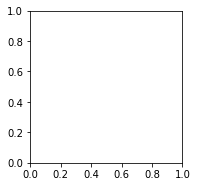

In [75]:
##input과 label이 맞나 확인
images,labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)
plt.subplot(1,2,1)
plt.imshow(images[0],cmap='gray')
plt.subplot(1,2,2)
plt.imshow(labels[0])
plt.show()

In [76]:
def compute_per_channel_dice(input, target, epsilon=1e-5, ignore_index=None, weight=None):
    # assumes that input is a normalized probability
    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    # mask ignore_index if present
    if ignore_index is not None:
        mask = target.clone().ne_(ignore_index)
        mask.requires_grad = False

        input = input * mask
        target = target * mask

    input = flatten(input)
    target = flatten(target)

    # Compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    denominator = (input + target).sum(-1)
    return 2. * intersect / denominator.clamp(min=epsilon)

def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order).contiguous()
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.view(C, -1)

class DiceLoss(nn.Module):
    """Computes Dice Loss, which just 1 - DiceCoefficient described above.
    Additionally allows per-class weights to be provided.
    """

    def __init__(self, epsilon=1e-5, weight=None, ignore_index=None, sigmoid_normalization=True,
                 skip_last_target=False):
        super(DiceLoss, self).__init__()
        if isinstance(weight, list):
            weight = torch.Tensor(weight)
            
        self.epsilon = epsilon
        self.register_buffer('weight', weight)
        self.ignore_index = ignore_index

        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)
        # if True skip the last channel in the target
        self.skip_last_target = skip_last_target

    def forward(self, input, target):
        # get probabilities from logits

        input = self.normalization(input)
        if self.weight is not None:
            weight = Variable(self.weight, requires_grad=False).to(input.device)
        else:
            weight = None

        if self.skip_last_target:
            target = target[:, :-1, ...]

        per_channel_dice = compute_per_channel_dice(input, target, epsilon=self.epsilon, ignore_index=self.ignore_index, weight=weight)
        # Average the Dice score across all channels/classes
        return torch.mean(1. - per_channel_dice)

In [77]:
import segmentation_models_pytorch as smp
model = smp.FPN(  #DeepLabV3
    encoder_name="resnet34",# choose encoder, e.g. mobilenet_v2 or efficientnet-b7 resnext101_32x8d,timm-res2net101_26w_4s     # use `imagenet` pre-trained weights for encoder initialization 
    encoder_weights="imagenet",
    in_channels=1,
    # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=1,                      # model output channels (number of classes in your dataset)
)

In [78]:
sum([param.nelement() for param in model.parameters()])

23149121

In [79]:
import torch.optim as optim
criterion =  DiceLoss(sigmoid_normalization=True)
optimizer = optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)


In [ ]:
n_epochs = 100
cnt =0
train_loss_min = np.Inf # track change in validation loss

# keep track of training and validation loss
train_loss = torch.zeros(n_epochs)


model.to(device)
for e in range(0, n_epochs):

    model.train()
    for data, labels in tqdm(train_loader):
        # move tensors to GPU if CUDA is available
        data, labels = data.float().to(device), labels.float().to(device) #cpu에 있는 데이터를 gpu에 보냄
    
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        logits = model(data)

        # calculate the batch loss
        loss = criterion(logits, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss[e] += loss.item()
       
    train_loss[e] /= len(train_loader)
    
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    train_loss_min,
    train_loss[e]))
    torch.save(model.state_dict(), 'model_best_1.pt')
   

  0%|          | 0/7150 [00:00<?, ?it/s]